In [1]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
if not hasattr(torch, 'concat'):
    torch.concat = torch.cat
import numpy as np
import os
import pandas as pd
import sys
import csv
import math
from einops import rearrange
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Fix the "AttributeError" for loading old models

In [2]:
import original
sys.modules['__main__'].AttentionPool = original.AttentionPool
sys.modules['__main__'].Encode = original.Encode
sys.modules['__main__'].stem_block = original.stem_block
sys.modules['__main__'].Resnet_block = original.Resnet_block
sys.modules['__main__'].resnet_module = original.resnet_module
sys.modules['__main__'].MHA_block = original.MHA_block
sys.modules['__main__'].feed_forward = original.feed_forward

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "model.pth"
model = torch.load(MODEL_PATH, map_location=device)
model.eval()

for module in model.modules():
    if hasattr(module, 'device'):
        module.device = device

cuda:0


## Load the data

In [3]:
class PredictionDataset(Dataset):
    """Dataset for making predictions on unlabeled sequences"""
    
    def seq2one_hot(self, seq):
        mapping = {'a': 0, 't': 1, 'u': 1, 'c': 2, 'g': 3, 'o': 4}
        onehot_matrix = np.vstack((np.eye(4), np.zeros(4)))
        seq_lower = [mapping.get(s.lower(), 4) for s in seq]
        return onehot_matrix[seq_lower]
    
    def __init__(self, sequences, max_len=64*2**7):
        super(PredictionDataset, self).__init__()
        self.sequences = sequences
        self.max_len = max_len

    def __getitem__(self, index):
        seq_id, seq = self.sequences[index]
        seq_result = self.seq2one_hot(seq)
        
        if len(seq) < self.max_len:
            len1 = (self.max_len - len(seq)) // 2
            len2 = (self.max_len - len(seq)) - len1
            seq_result = np.pad(seq_result, ((len1, len2), (0, 0)), 'constant', constant_values=(0, 0))
        elif len(seq) > self.max_len:
            half = self.max_len // 2
            seq = seq[:half] + seq[-half:]
            seq_result = self.seq2one_hot(seq)                    
        
        return seq_id, torch.from_numpy(seq_result).type(torch.float)
    
    def __len__(self):
        return len(self.sequences)

    def parse_fasta(fasta_file):
        """Parse FASTA file and extract sequences"""
        
        sequences = []
        current_seq = ""
        seq_id = ""
        
        print(f"Reading {fasta_file}...")
        with open(fasta_file, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('>'):
                    if current_seq:
                        sequences.append((seq_id, current_seq))
                    seq_id = line[1:]  # Remove '>'
                    current_seq = ""
                else:
                    current_seq += line
            
            # Include the last sequence
            if current_seq:
                sequences.append((seq_id, current_seq))
        
        return sequences

## In-silico Mutagenesis on the Whole Transcript

### preparation

In [4]:

# def mutate_block(seq, start_pos, step_size):
#     """Replaces a specific 10-nt block with random bases."""
#     seq_list = list(seq)
#     bases = ['a', 'c', 'g', 't']
#     end_pos = min(start_pos + step_size, len(seq))
    
#     for i in range(start_pos, end_pos):
#         seq_list[i] = random.choice(bases)  
#     return "".join(seq_list)

def shuffle_block(seq, start_pos, block_size):
    """
    Shuffle nucleotides within a block.
    Preserves composition but destroys motif patterns.
    """
    seq_list = list(seq)
    end_pos = min(start_pos + block_size, len(seq))
    block = seq_list[start_pos:end_pos]
    random.shuffle(block)
    # Put it back
    seq_list[start_pos:end_pos] = block
    return "".join(seq_list)


# def calculate_jsd(p_probs, q_probs):
#     """Calculates Jensen-Shannon Divergence (always non-negative)."""
#     p = torch.as_tensor(p_probs, dtype=torch.float32).flatten()
#     q = torch.as_tensor(q_probs, dtype=torch.float32).flatten()
    
#     # Normalize to probability distributions
#     p = p / (p.sum() + eps)
#     q = q / (q.sum() + eps)
    
#     # Clamp to avoid log(0)
#     p = p.clamp(min=eps)
#     q = q.clamp(min=eps)
#     m = (0.5 * (p + q)).clamp(min=eps)
    
#     # Manual KL: KL(P || M) = Σ P * log(P / M)
#     kl_pm = (p * (p.log() - m.log())).sum()
#     kl_qm = (q * (q.log() - m.log())).sum()
    
#     jsd = 0.5 * (kl_pm + kl_qm)
#     return max(0.0, jsd.item())

def calculate_class_impact(p_probs, q_probs):
    """Calculate the absolute divergence in each class direcly."""
    p = np.array(p_probs).flatten()
    q = np.array(q_probs).flatten()
    deltas = p - q
    weight = np.sqrt(np.maximum(p, q))  # Weight by higher value in case of suppression

    return deltas*weight
    


In [5]:
# CONFIGURATION
STEP = 20 
MAX_LEN = 8192
eps = 1e-7

label_names = [
    "chromatin", "cytoplasm", "cytosol", "ER", "extracellular", 
    "membrane", "mitochondrion", "nucleolus", "nucleoplasm", "nucleus", "ribosome"
]

@torch.no_grad()
def run_ism(model, seq_id, original_text, device):
    ds_helper = PredictionDataset([])
    
    seq_len = len(original_text)
    block_starts = range(0, seq_len, STEP)
    
    def get_probs(s):
        if len(s) > MAX_LEN:
            half = MAX_LEN // 2
            processed = s[:half] + s[-half:]
        else:
            p_len = MAX_LEN - len(s)
            l1 = p_len // 2
            processed = ("o" * l1) + s + ("o" * (p_len - l1))
            
        onehot = ds_helper.seq2one_hot(processed)
        inp = torch.from_numpy(onehot).type(torch.float).unsqueeze(0).to(device)
        outputs = model(inp, norm="layer_norm", mask=None)
        probs = outputs.cpu().numpy()
  
        return probs
        
    p_orig = get_probs(original_text)
    
    results = []

    for start in block_starts:
        deltas_reps = []
        
        # Define the 3 offset positions
        offsets = [0, -5, +5]
        for offset in offsets:
            actual_start = start + offset
            
            # Boundary adjustments
            if actual_start < 0:
                actual_start = 0
            if actual_start + STEP > seq_len:
                actual_start = seq_len - STEP
                
            mut_seq = shuffle_block(original_text, actual_start, STEP)
            p_mut = get_probs(mut_seq)
            
            deltas = calculate_class_impact(p_orig, p_mut)
            deltas_reps.append(deltas)
        
        # Take max if any offset hits a motif, mean to mitigate the randomness
        deltas_array = np.array(deltas_reps)  # Shape: (3, 11) - 3 offsets × 11 classes
 
        # Find which offset has the largest absolute value
        max_abs_idx = np.abs(deltas_array).argmax(axis=0)  # (11,) 
        # Get the original signed value at that index
        deltas_max = deltas_array[max_abs_idx, np.arange(len(label_names))]
        
        deltas_mean = deltas_array.mean(axis=0)  # (11,)
        deltas_var = deltas_array.std(axis=0) 

        # Store each class as separate column
        row = {'start': start, 'end': start + STEP}
        for i, class_name in enumerate(label_names):
            row[f'{class_name}_max'] = deltas_max[i]
            row[f'{class_name}_mean'] = deltas_mean[i]
            row[f'{class_name}_var'] = deltas_var[i]

        results.append(row)

    return pd.DataFrame(results), p_orig

### Execution

In [6]:
# Load Data
REAL_DATA_PATH = "FASTA.txt"
raw_data = PredictionDataset.parse_fasta(REAL_DATA_PATH)

# Storage for the saliency maps
saliency_results = {}

# Get the top isoforms
dataframe = pd.read_csv("candidates_valid.csv")
target_isoforms = dataframe['Isoforms'].unique()

print(f"Starting ISM")

num = 0
for seq_id in target_isoforms:
    num = num + 1
    if num % 10 == 0:
        print(f"Processed {num} sequences...")
    
    try:
        original_text = next(s[1] for s in raw_data if str(s[0]) == str(seq_id))
    except StopIteration:
        print(f"Skipping {seq_id}: Sequence not found.")
        continue
    
    df_map, p_orig = run_ism(model, seq_id, original_text, device)
    
    saliency_results[seq_id] = {
        'map': df_map,
        'baseline_prob': p_orig,
        'seq_len': len(original_text)
    }
    
 #   print(f" Completed {seq_id} | Blocks scanned: {len(df_map)}")

print("\nAll transcripts scanned successfully!")

Reading FASTA.txt...
Starting ISM
Processed 10 sequences...
Processed 20 sequences...
Processed 30 sequences...
Processed 40 sequences...
Processed 50 sequences...
Processed 60 sequences...
Processed 70 sequences...
Processed 80 sequences...
Processed 90 sequences...
Processed 100 sequences...
Processed 110 sequences...
Processed 120 sequences...
Processed 130 sequences...
Processed 140 sequences...
Processed 150 sequences...
Processed 160 sequences...
Processed 170 sequences...
Processed 180 sequences...
Processed 190 sequences...
Processed 200 sequences...
Processed 210 sequences...
Processed 220 sequences...
Processed 230 sequences...
Processed 240 sequences...
Processed 250 sequences...
Processed 260 sequences...
Processed 270 sequences...
Processed 280 sequences...
Processed 290 sequences...
Processed 300 sequences...
Processed 310 sequences...
Processed 320 sequences...
Processed 330 sequences...
Processed 340 sequences...
Processed 350 sequences...
Processed 360 sequences...
Pro

### Save the Results

In [7]:
import pickle

saliency_file = "ism_saliency_maps.pkl"

with open(saliency_file, 'wb') as f:
    pickle.dump(saliency_results, f)

print(f" Saliency maps for {len(saliency_results)} transcripts saved to {saliency_file}")

✅ Saliency maps for 1455 transcripts saved to ism_saliency_maps.pkl


### Plot (can be skipped)

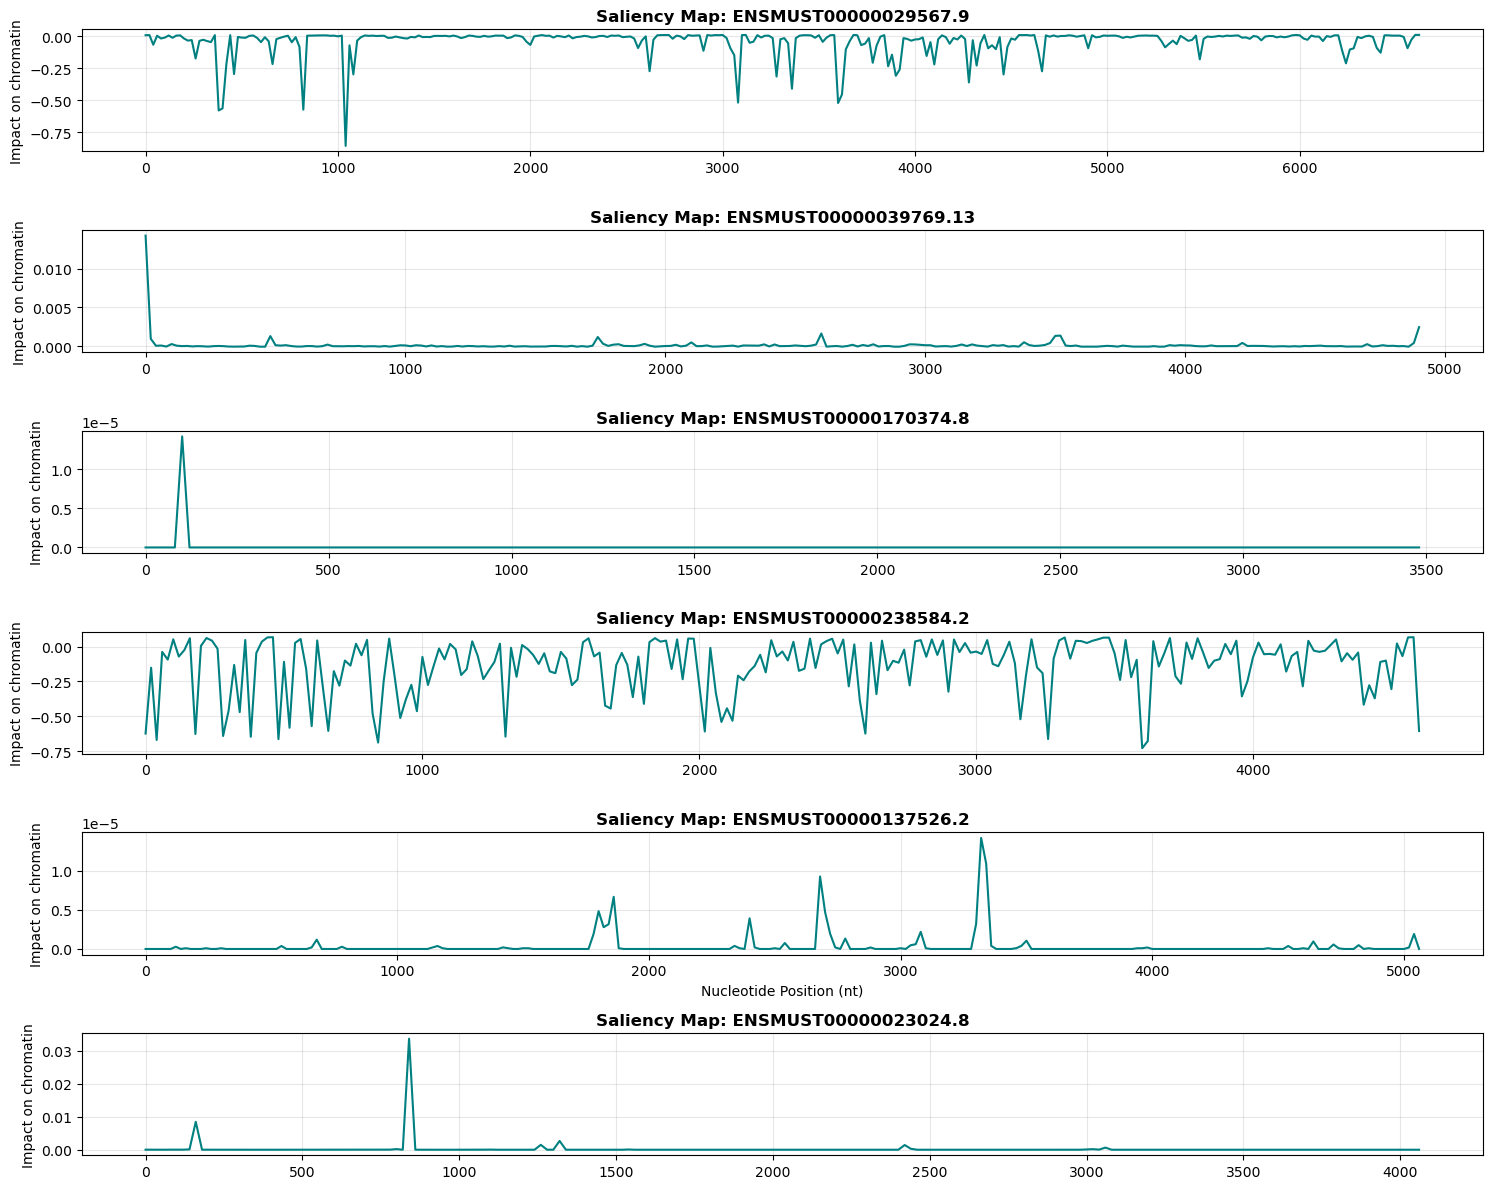

In [9]:
TARGET_CLASS = "chromatin"

plt.figure(figsize=(15, 12))

plt_num = 6

for i, seq_id in enumerate(target_isoforms, 1):
    if i > plt_num:
        break
    
    df_map = saliency_results[seq_id]['map']

    max_col = f'{TARGET_CLASS}_max'
    mean_col = f'{TARGET_CLASS}_mean'
        
    # Weighted score
    score = (0.7 * df_map[max_col]) + (0.3 * df_map[mean_col])
    
    plt.subplot(plt_num, 1, i)
    plt.plot(df_map['start'], score, color='teal', linewidth=1.5)
    
    # Add labels and formatting
    plt.title(f"Saliency Map: {seq_id}", fontsize=12, fontweight='bold')
    plt.ylabel(f"Impact on {TARGET_CLASS}")
    if i == plt_num - 1: plt.xlabel("Nucleotide Position (nt)")
    plt.grid(alpha=0.3)
    plt.tight_layout()

plt.show()

### Extract the Sequences in Each Cluster

In [11]:
# CONFIGURATION
ROI_SIZE = 50
MASK_RADIUS = ROI_SIZE // 2 
MAX_ROIS = 5
RATIO_THRESH = 0.6
ABSOLUTE_THRESH = 0.2
WEIGHT_MAX = 0.7
WEIGHT_MEAN = 0.3
PROB_THRESHOLD = 0.5  # Threshold for positive or negative bucket


bucket_cols = {
    'chromatin': 'chromatin_prob',
    'cytoplasm': 'cytoplasm_prob',
    'cytosol': 'cytosol_prob',
    'ER': 'endoplasmic reticulum_prob',
    'extracellular': 'extracellular region_prob',
    'membrane': 'membrane_prob',
    'mitochondrion': 'mitochondrion_prob',
    'nucleolus': 'nucleolus_prob',
    'nucleoplasm': 'nucleoplasm_prob',
    'nucleus': 'nucleus_prob',
    'ribosome': 'ribosome_prob'
}

# Load original predictions
df_predictions = pd.read_csv("Prediction.csv")

# Create lookup dict: seq_id -> row
pred_lookup = {row['sequence_id']: row for _, row in df_predictions.iterrows()}

# Master Dictionary: class_name -> {'positive': {seq_id: motifs}, 'negative': {seq_id: motifs}}
class_motif_registry = {
    name: {'positive': {}, 'negative': {}} 
    for name in label_names
}

processed_ids = list(saliency_results.keys())
print(f"Extracting up to {MAX_ROIS} motifs for {len(processed_ids)} transcripts...")

# Extract for each class independently
for class_name in label_names:
    print(f"\n Processing: {class_name}")
    
    pos_motifs_num = 0
    neg_motifs_num = 0
    pos_transcripts = 0
    neg_transcripts = 0
    
    # Find the actual column name in predictions
    col_pattern = bucket_cols[class_name]
    pred_col = next((c for c in df_predictions.columns if col_pattern in c), None)
    
    if not pred_col:
        print(f" Could not find prediction column for {class_name}")
        continue
    
    for seq_id in processed_ids:
        # Get the map and sequence
        df_map = saliency_results[seq_id]['map'].copy()
        
        try:
            original_text = next(s[1] for s in raw_data if str(s[0]) == str(seq_id))
        except StopIteration:
            continue 
        
        # Get original prediction for this class
        if seq_id not in pred_lookup:
            continue
        orig_prob = pred_lookup[seq_id].get(pred_col, 0)
        
        # Determine bucket: positive (prob > 0.5) or negative
        if orig_prob > PROB_THRESHOLD:
            bucket = 'positive'
        else:
            bucket = 'negative'
            
        seq_len = len(original_text)
        motifs_found = []
       
        if df_map.empty: 
            continue
            
        # Use THIS CLASS's columns
        max_col = f'{class_name}_max'
        mean_col = f'{class_name}_mean'
        var_col = f'{class_name}_var'
        
        # Weighted score for this class (use absolute for finding peaks)
        df_map['score'] = (WEIGHT_MAX * np.abs(df_map[max_col])) + (WEIGHT_MEAN * np.abs(df_map[mean_col]))
        
        # Keep original signed value for reporting
        df_map['signed_impact'] = (WEIGHT_MAX * df_map[max_col]) + (WEIGHT_MEAN * df_map[mean_col])
        
        # Find Global Max for this class
        global_max = df_map['score'].max()
        
        # Skip if no significant signal for this class
        if global_max < ABSOLUTE_THRESH:
            continue
        
        # Iterative Peak Picking Loop
        for i in range(MAX_ROIS):
            current_max = df_map['score'].max()
            
            if current_max <= ABSOLUTE_THRESH: 
                break 
            
            if current_max < (global_max * RATIO_THRESH):
                break
                
            # Find current highest point
            peak_idx = df_map['score'].idxmax()
            peak_val = df_map.loc[peak_idx, 'score']
            peak_signed = df_map.loc[peak_idx, 'signed_impact']
            peak_pos = df_map.loc[peak_idx, 'start']
            peak_var = df_map.loc[peak_idx, var_col]
            peak_confid = peak_val / (peak_var + 1e-7)
            
            # Define window
            start_win = max(0, peak_pos - (ROI_SIZE // 2))
            end_win = min(seq_len, start_win + ROI_SIZE)
            
            if end_win == seq_len:
                start_win = max(0, seq_len - ROI_SIZE)
                
            roi_seq = original_text[start_win:end_win]
            
            # Determine motif type based on signed impact
            if peak_signed > 0:
                motif_type = 'promoter' 
            else:
                motif_type = 'suppressor' 
            
            # Store Motif Data
            motifs_found.append({
                'rank': i + 1,
                'peak_pos': peak_pos,
                'impact': peak_val,
                'signed_impact': peak_signed,
                'var': peak_var,
                'confidence': peak_confid,
                'motif_type': motif_type,
                'orig_prob': orig_prob,
                'sequence': roi_seq
            })
            
            # MASK OUT this region
            mask_start = max(0, peak_pos - MASK_RADIUS)
            mask_end = min(seq_len, peak_pos + MASK_RADIUS)
            mask_condition = (df_map['start'] >= mask_start) & (df_map['start'] <= mask_end)
            df_map.loc[mask_condition, 'score'] = 0

        # Save to class-specific registry
        if motifs_found:
            class_motif_registry[class_name][bucket][seq_id] = motifs_found
            if bucket == 'positive':
                pos_motifs_num += len(motifs_found)
                pos_transcripts += 1
            else:
                neg_motifs_num += len(motifs_found)
                neg_transcripts += 1

    print(f"  Positive bucket: {pos_transcripts} transcripts and {pos_motifs_num} motifs")
    print(f"  Negative bucket: {neg_transcripts} transcripts and {neg_motifs_num} motifs")


Extracting up to 5 motifs for 1455 transcripts...

 Processing: chromatin
  Positive bucket: 298 transcripts and 849 motifs
  Negative bucket: 269 transcripts and 828 motifs

 Processing: cytoplasm
  Positive bucket: 293 transcripts and 697 motifs
  Negative bucket: 178 transcripts and 533 motifs

 Processing: cytosol
  Positive bucket: 198 transcripts and 515 motifs
  Negative bucket: 143 transcripts and 353 motifs

 Processing: ER
  Positive bucket: 35 transcripts and 139 motifs
  Negative bucket: 105 transcripts and 266 motifs

 Processing: extracellular
  Positive bucket: 95 transcripts and 190 motifs
  Negative bucket: 10 transcripts and 45 motifs

 Processing: membrane
  Positive bucket: 280 transcripts and 764 motifs
  Negative bucket: 237 transcripts and 710 motifs

 Processing: mitochondrion
  Positive bucket: 249 transcripts and 587 motifs
  Negative bucket: 169 transcripts and 443 motifs

 Processing: nucleolus
  Positive bucket: 328 transcripts and 856 motifs
  Negative buc

### just for check

In [12]:
# Check if motifs match expected type for each bucket
print("Validating motif types match bucket expectations...\n")

for class_name in label_names:
    print(f"{class_name}:")
    
    for bucket in ['positive', 'negative']:
        registry = class_motif_registry[class_name][bucket]
        
        if not registry:
            print(f"  {bucket}: No motifs")
            continue
        
        # Count signed impacts
        positive_impacts = 0
        negative_impacts = 0
        total = 0
        
        for seq_id, motifs in registry.items():
            for motif in motifs:
                total += 1
                if motif['signed_impact'] > 0:
                    positive_impacts += 1
                else:
                    negative_impacts += 1
        
        print(f"  {bucket}: {total} motifs | +:{positive_impacts} ({actual_pct_positive:.1f}%)")
    
    print()

Validating motif types match bucket expectations...

chromatin:
  positive: 849 motifs | +:833 (98.1%) | -:16 (1.9%) | Expected: promoters (+) ✓
  negative: 828 motifs | +:0 (0.0%) | -:828 (100.0%) | Expected: suppressors (-) ✓

cytoplasm:
  positive: 697 motifs | +:671 (96.3%) | -:26 (3.7%) | Expected: promoters (+) ✓
  negative: 533 motifs | +:0 (0.0%) | -:533 (100.0%) | Expected: suppressors (-) ✓

cytosol:
  positive: 515 motifs | +:506 (98.3%) | -:9 (1.7%) | Expected: promoters (+) ✓
  negative: 353 motifs | +:0 (0.0%) | -:353 (100.0%) | Expected: suppressors (-) ✓

ER:
  positive: 139 motifs | +:139 (100.0%) | -:0 (0.0%) | Expected: promoters (+) ✓
  negative: 266 motifs | +:0 (0.0%) | -:266 (100.0%) | Expected: suppressors (-) ✓

extracellular:
  positive: 190 motifs | +:188 (98.9%) | -:2 (1.1%) | Expected: promoters (+) ✓
  negative: 45 motifs | +:0 (0.0%) | -:45 (100.0%) | Expected: suppressors (-) ✓

membrane:
  positive: 764 motifs | +:747 (97.8%) | -:17 (2.2%) | Expected: p

## Motif Identification

### export for MEME

In [14]:
def export_for_meme(class_motif_registry, output_dir="meme_input_split"):
    """Export class-specific motifs as separate FASTA files for positive/negative."""
    os.makedirs(output_dir, exist_ok=True)
    
    for class_name in label_names:
        for bucket in ['positive', 'negative']:
            registry = class_motif_registry[class_name][bucket]
            
            if not registry:
                continue
            
            fasta_path = os.path.join(output_dir, f"{class_name}_{bucket}_motifs.fasta")
            
            with open(fasta_path, 'w') as f:
                seq_idx = 0
                for seq_id, motifs in registry.items():
                    for motif in motifs:
                        seq_idx += 1
                        sign = "pro" if motif['motif_type'] == 'promoter' else "supp"
                        header = f">{seq_id}_rank{motif['rank']}_pos{motif['peak_pos']}_{motif['signed_impact']:.3f}_{sign}"
                        f.write(f"{header}\n{motif['sequence']}\n")
                        
export_for_meme(class_motif_registry)
print("```Everything is done!```")

```Everything is done!```
